## 4. Lucy FFNN Models (extension to "4_Model_Training.ipynb")

In [1]:
# Standard
import pandas as pd
import numpy as np 

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.core.display import Image, display
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


 ------ LUCY EDITS: -------------------------------------------------- 

In [ ]:
#### EDITED FROM: `IPython.core.display import Image, display` due to deprecation 
from IPython.display import Image, display
# classifier for zero rate regression
from sklearn.dummy import DummyClassifier


 ------ END LUCY EDITS: -------------------------------------------------- 

# Load and prepare data

In [2]:
# Load train file

#-------------------------------------------------------------------------
# ---------LUCY EDIT: USING MY VERSION OF split_train_clean/split_test_clean here 
train_file = 'split_train_clean.csv' # NOTE: MY VERSION
train = pd.read_csv(train_file) 

# Load test file
test_file = 'split_test_clean.csv' # NOTE: MY VERSION 
test = pd.read_csv(test_file)
#-------------------------------------------------------------------------

print(f'Shape of train file: {train.shape}')
print(f'Shape of test file: {test.shape}')
print(f'Train cols: {train.columns}')

Shape of train file: (11994, 96)
Shape of test file: (2999, 96)
Train cols: Index(['Unnamed: 0', 'Type', 'Age', 'Breed1_0', 'Breed1_1', 'Breed1_2',
       'Breed1_3', 'Breed1_4', 'Breed1_5', 'Breed1_6', 'Breed1_7', 'Breed2_0',
       'Breed2_1', 'Breed2_2', 'Breed2_3', 'Breed2_4', 'Breed2_5', 'Breed2_6',
       'MaturitySize', 'FurLength', 'Vaccinated_1', 'Vaccinated_2',
       'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3',
       'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health', 'Quantity',
       'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3', 'VideoAmt',
       'PetID', 'PhotoAmt', 'AdoptionSpeed', 'vertex_xs', 'vertex_ys',
       'bounding_confidences', 'bounding_importance_fracs', 'dominant_blues',
       'dominant_greens', 'dominant_reds', 'dominant_pixel_fracs',
       'dominant_scores', 'label_descriptions_0', 'label_descriptions_1',
       'label_descriptions_2', 'label_descriptions_3', 'label_descriptions_4',
       'label_descriptions_5', 'label

In [ ]:
# data pre-processing checks 
train_cols = train.columns
train[train_cols[0:10]].describe()

In [ ]:
train[train_cols[10:20]].describe()

In [ ]:
train[train_cols[20:30]].describe()

In [ ]:
train[train_cols[30:40]].describe()

In [ ]:
train[train_cols[40:50]].describe()

In [ ]:
train[train_cols[50:60]].describe()

In [ ]:
train[train_cols[60:70]].describe()

In [ ]:
train[train_cols[70:80]].describe()

In [ ]:
train[train_cols[80:90]].describe()

In [ ]:
train[train_cols[90:100]].describe()

In [3]:
# Group 0 & 1 and relabel target variable in train and test
relabel_dict = { 0:0, 1:0, 2:1, 3:2, 4:3}
train['AdoptionSpeed'] = train['AdoptionSpeed'].map(relabel_dict)
test['AdoptionSpeed'] = test['AdoptionSpeed'].map(relabel_dict)

# Value counts of re-labeled AdoptionSpeed
train['AdoptionSpeed'].value_counts()

AdoptionSpeed
3    3364
1    3231
0    2781
2    2618
Name: count, dtype: int64

In [4]:
x_train = train.loc[:, train.columns!='AdoptionSpeed']
x_train = train.loc[:, train.columns!='PetID'] # remove pet id col 
print(f'Shape of x_train: {x_train.shape}')

y_train = train.loc[:, train.columns=='AdoptionSpeed']
print(f'Shape of y_train: {y_train.shape}')

x_test = test.loc[:, test.columns!='AdoptionSpeed']
x_test = test.loc[:, test.columns!='PetID'] # remove pet id col 
print(f'Shape of x_test: {x_test.shape}')

y_test = test.loc[:, test.columns=='AdoptionSpeed'] # remove pet id col 
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (11994, 95)
Shape of y_train: (11994, 1)
Shape of x_test: (2999, 95)
Shape of y_test: (2999, 1)


In [13]:
# Apply StandadScaler
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)

scaler = StandardScaler()
x_test_std = scaler.fit_transform(x_test)

In [25]:

indices = np.arange(x_train_std.shape[0])
indices
# shuffled_indices = np.random.permutation(indices)
# y_train = y_train[shuffled_indices]
#y_train.shape

array([    0,     1,     2, ..., 11991, 11992, 11993])

## Define NN functions 

In [10]:
# Apply random shufflying to training examples.
# def random_shuffle_examples(X_train, Y_train):
#     np.random.seed(0)
#     indices = np.arange(X_train.shape[0])
#     shuffled_indices = np.random.permutation(indices)
#     X_train = X_train[shuffled_indices]
#     Y_train = Y_train[shuffled_indices]
#     return X_train,Y_train

In [34]:
# Build basic FFNN model
def build_model(n_classes=4,
                hidden_layer_sizes=[],
                activation='relu', # relu = default
                optimizer='Adam', # Adam = default
                learning_rate=0.01):
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
                    
    optimizer_class = getattr(tf.keras.optimizers, optimizer) # specificy optimizer from argument 
    optimizer = optimizer_class(learning_rate=learning_rate)
                    
    model = tf.keras.Sequential()
    model.add(keras.layers.Flatten()) # serves as input layer 
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation,
                                        kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4)) # each hidden layer uses same activation
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax',name='Output')) # output units = n_classes 

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer = optimizer,
        metrics=['accuracy'])

    return model

SyntaxError: invalid syntax (3539899102.py, line 21)

In [ ]:
# Plot trainig history 
# def plot_history(history): 
#     hist = history.history
#     x_arr = np.arange(len(hist['loss'])) + 1
#     fig = plt.figure(figsize=(12, 4))
    
#     ax = fig.add_subplot(1, 2, 1)
#     ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
#     ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
#     ax.legend(fontsize=15)
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Loss', size=15)
    
#     ax = fig.add_subplot(1, 2, 2)
#     ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
#     ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
#     ax.legend(fontsize=15)
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Accuracy', size=15)
#     ax.set_ylim(0,0.6)
#     plt.show()

## 0. Baseline Model: Zero Rate Regression

Our baseline model uses zero rate regression based on the most frequent outcome class (AdoptionSpeed = 4). 

In [ ]:
# check counts by class
y_train.value_counts().sort_values() # most frequent class is adoption speed = 3

### ZRR train set score 

In [ ]:
# Baseline model 1: zero-rate classifier 
## predict value of most frequent class (4)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.predict(x_train)

# Return the mean accuracy on the given TRAIN (was: test) data and labels.
dummy_clf.score(x_train, y_train)

Our simple baseline model has a train accuracy of approximately 0.28. Subsequent models must perform at least as well as this baseline in order to be useful. 

"In multi-label classification, this is the subset accuracy which is a harsh metric 
because it requires for each sample that each label set be correctly predicted."

## 1. Model 1: FFNN

Average train accuracy last 5 epochs: 0.3676116466522217
Average val_accuracy last 5 epochs: 0.27216667532920835


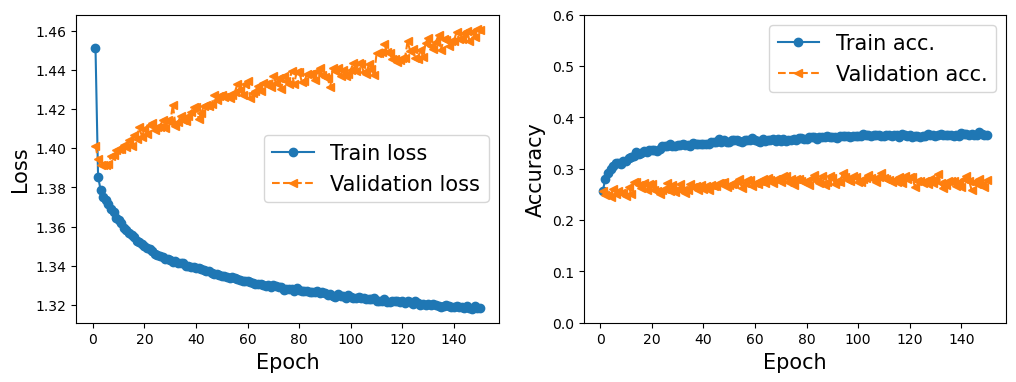

In [31]:
# set seeds again? 

# random shuffle training examples 
# indices = np.arange(x_train_std.shape[0])
# shuffled_indices = np.random.permutation(indices) 
# x_train_std = x_train_std[shuffled_indices]
# y_train = y_train[shuffled_indices]

model = build_model(n_classes=4,
                    hidden_layer_sizes=[7,7],
                    activation='relu', # relu = default
                    optimizer='Adam', # Adam = default
                    learning_rate=0.001)

history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()


Average train accuracy last 5 epochs: 0.2303282916545868
Average val_accuracy last 5 epochs: 0.23801583051681519


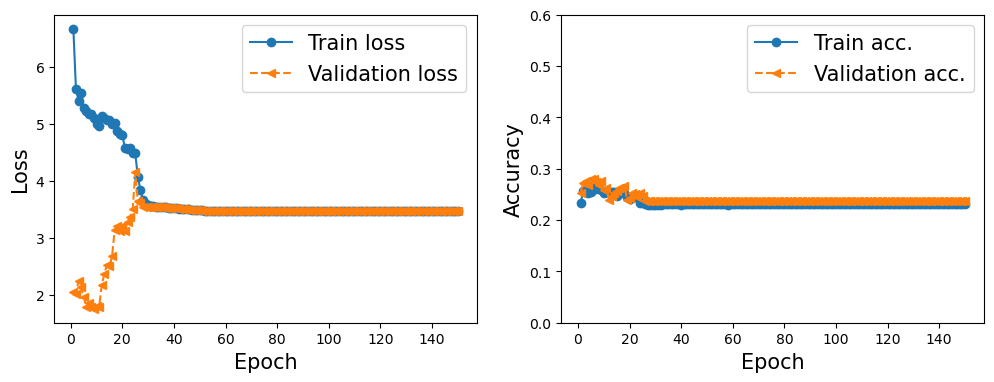

In [39]:
# w/ dropout layer added 
n_classes=4
hidden_layer_sizes=[7,7]
activation='relu' # relu = default
optimizer='Adam' # Adam = default
learning_rate=0.001
num_features = x_train_std.shape[0]

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
                    
optimizer_class = getattr(tf.keras.optimizers, optimizer) # specificy optimizer from argument 
optimizer = optimizer_class(learning_rate=learning_rate)

model = tf.keras.Sequential()

#model.add(keras.layers.Flatten()) # serves as input layer 
# for hidden_layer_size in hidden_layer_sizes:
#         model.add(tf.keras.layers.Dense(units=hidden_layer_size,
#                                         activation=activation,
#                                         kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4)) # each hidden layer uses same activation
# model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax',name='Output')) # output units = n_classes 

# Input layer
model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
# First Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=64, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_1'))   
model.add(tf.keras.layers.Dropout(0.25))
#model.add(tf.keras.layers.BatchNormalization())
    
    # Second Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=32, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_2'))
model.add(tf.keras.layers.Dropout(0.25))

                  
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy'])


history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.2,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()


11994

Average train accuracy last 5 epochs: 0.33716880679130556
Average val_accuracy last 5 epochs: 0.23633333742618562


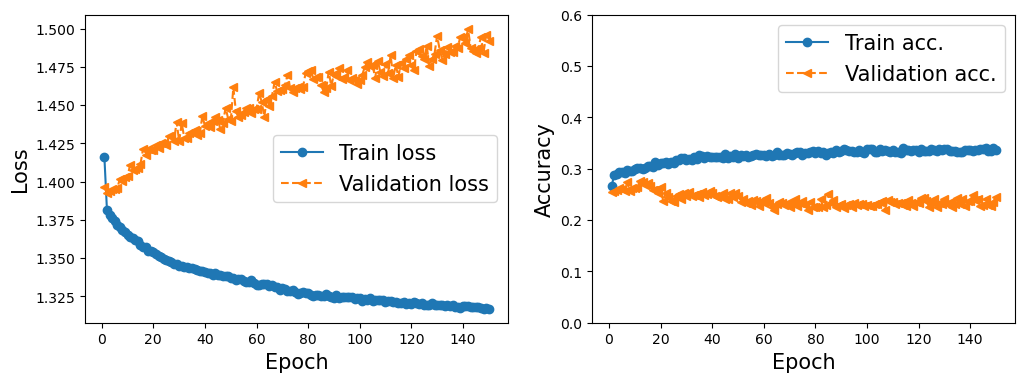

In [35]:
# with regularization
model = build_model(n_classes=4,
                    hidden_layer_sizes=[7,7],
                    activation='relu', # relu = default
                    optimizer='Adam', # Adam = default
                    learning_rate=0.001)

history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=8,
    validation_split=0.1,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()


In [ ]:
# with regularization
model = build_model(n_classes=4,
                    hidden_layer_sizes=[7,7],
                    activation='relu', # relu = default
                    optimizer='Adam', # Adam = default
                    learning_rate=0.001)

history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=8,
    validation_split=0.1,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

Average train accuracy last 5 epochs: 0.2305784285068512
Average val_accuracy last 5 epochs: 0.2379324644804001


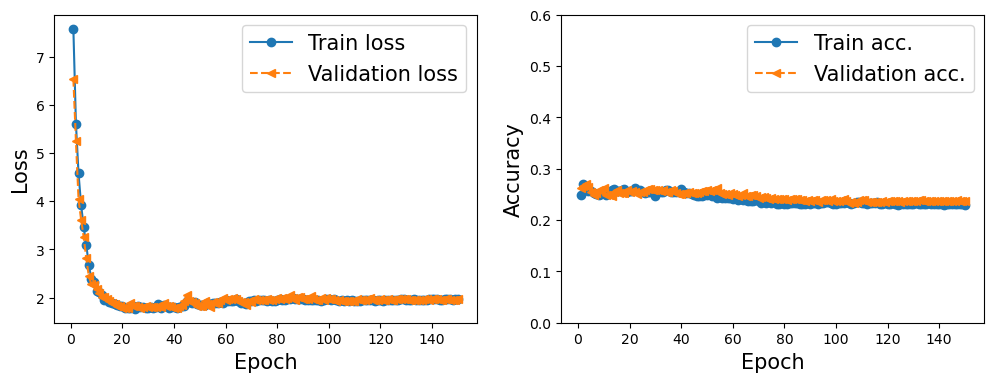

In [41]:
# w/ dropout layer added 
n_classes=4
hidden_layer_sizes=[7,7]
activation='relu' # relu = default
optimizer='Adam' # Adam = default
learning_rate=0.001
num_features = x_train_std.shape[1]

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
                    
optimizer_class = getattr(tf.keras.optimizers, optimizer) # specificy optimizer from argument 
optimizer = optimizer_class(learning_rate=learning_rate)

model = tf.keras.Sequential()

#model.add(keras.layers.Flatten()) # serves as input layer 
# for hidden_layer_size in hidden_layer_sizes:
#         model.add(tf.keras.layers.Dense(units=hidden_layer_size,
#                                         activation=activation,
#                                         kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4)) # each hidden layer uses same activation
# model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax',name='Output')) # output units = n_classes 

# Input layer
model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
# First Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=7, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_1'))   
model.add(tf.keras.layers.Dropout(0.25))
#model.add(tf.keras.layers.BatchNormalization())
    
    # Second Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=7, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_2'))
#model.add(tf.keras.layers.Dropout(0.25))

                  
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy'])


history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.2,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

#### Same model as above, but with val split = 0.4

Average train accuracy last 5 epochs: 0.23012784123420715
Average val_accuracy last 5 epochs: 0.23447269201278687


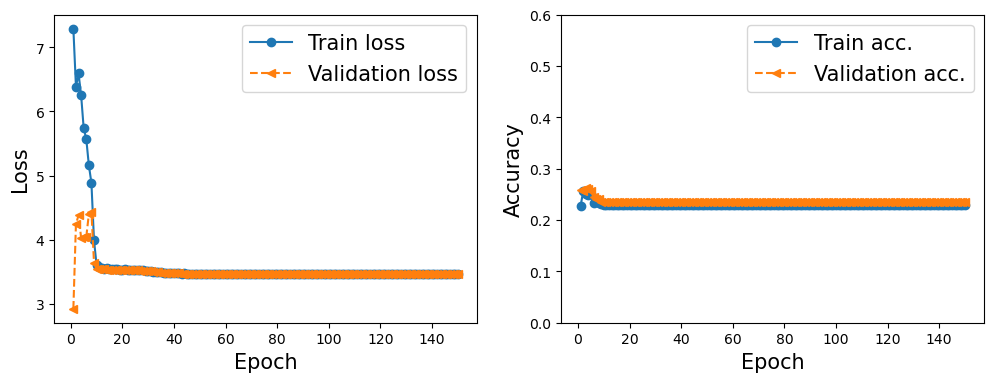

In [43]:
# w/ dropout layer added 
n_classes=4
hidden_layer_sizes=[7,7]
activation='relu' # relu = default
optimizer='Adam' # Adam = default
learning_rate=0.001
num_features = x_train_std.shape[1]

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
                    
optimizer_class = getattr(tf.keras.optimizers, optimizer) # specificy optimizer from argument 
optimizer = optimizer_class(learning_rate=learning_rate)

model = tf.keras.Sequential()

#model.add(keras.layers.Flatten()) # serves as input layer 
# for hidden_layer_size in hidden_layer_sizes:
#         model.add(tf.keras.layers.Dense(units=hidden_layer_size,
#                                         activation=activation,
#                                         kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4)) # each hidden layer uses same activation
# model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax',name='Output')) # output units = n_classes 

# Input layer
model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
# First Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=64, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_1'))   
model.add(tf.keras.layers.Dropout(0.25))
#model.add(tf.keras.layers.BatchNormalization())
    
    # Second Dense and dropout layer 
model.add(tf.keras.layers.Dense(units=32, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                name='fc_2'))
model.add(tf.keras.layers.Dropout(0.25))

                  
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy'])


history = model.fit(
    x=x_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.4,
    verbose=0)

print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

# Results Summary Table

FEATURES | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | NUM EPOCHS | TRAIN ACCURACY | VAL ACCURACY | TEST ACCURACY
-|-|-|-|-|-|-|-|-
core feature set | [],[128] | [256,128] | tanh,relu | SGD,Adam |  0.001,0.01 | . | . | . 
_ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _